In [3]:
import os
import warnings
import numpy as np
import pandas as pd
import math
from matplotlib import pyplot as plt
%matplotlib inline

from PIL import Image
from skimage import measure, io, color
from skimage.transform import resize, rescale
from skimage.measure import label, regionprops
from skimage.color import label2rgb
from skimage.morphology import convex_hull_image
from scipy.stats import mode
from sklearn.cluster import DBSCAN, KMeans

try:
    os.chdir("/media/ryan/hdd/Dropbox/1_proj/logos/")
except:
    os.chdir("/Users/ryan/Dropbox/1_proj/logos/")

### Helper functions:

In [4]:
def alpha_to_color(image, color=(255, 255, 255)):
    """Alpha composite an RGBA Image with a specified color.

    Simpler, faster version than the solutions above.

    Source: http://stackoverflow.com/a/9459208/284318

    Keyword Arguments:
    image -- PIL RGBA Image object
    color -- Tuple r, g, b (default 255, 255, 255)

    """
    image.load()  # needed for split()
    background = Image.new('RGB', image.size, color)
    background.paste(image, mask=image.split()[3])  # 3 is the alpha channel
    return background


def standardize(image):
    if len(image.shape)==2:
        image = color.gray2rgb(image)

    if len(image.shape)>3:
        image = image[:,:,:,0]

    if image.shape[2]==4:
        image = Image.fromarray(image)
        image = alpha_to_color(image)
        image = np.array(image)
        
    return image


def remove_white_bg(img):
    
    img_gray = color.rgb2gray(img)
    
    h, w = tuple(img_gray.shape)

    keep_row = np.zeros(h, dtype='Bool')
    for row in range(h):
        keep_row[row] = (np.sum(np.sum(img_gray[row,:]<0.98,axis=0))>0)

    keep_col = np.ones(w, dtype='Bool')
    for col in range(w):
        keep_col[col] = (np.sum(np.sum(img_gray[:,col]<0.98,axis=0))>0)

    img_nobg = img[keep_row,:]
    img_nobg = img_nobg[:,keep_col]
    
    return img_nobg


def remove_segmentation_bg(img):
      
    h, w = tuple(img.shape)

    keep_row = np.zeros(h, dtype='Bool')
    for row in range(h):
        keep_row[row] = (np.sum(img[row,:])>0)

    keep_col = np.ones(w, dtype='Bool')
    for col in range(w):
        keep_col[col] = (np.sum(img[:,col])>0)

    img_nobg = img[keep_row,:]
    img_nobg = img_nobg[:,keep_col]
    
    return img_nobg


def add_padding(img, bgval, pad_size=20):
    side_pad = np.full((img.shape[0], pad_size, 3), bgval, dtype='uint8')
    tb_pad = np.full((pad_size, img.shape[1] + 2*pad_size, 3), bgval, dtype='uint8')
    padded_img = np.vstack((tb_pad, np.hstack((side_pad, img, side_pad)), tb_pad))
    return padded_img


def add_quantized_padding(img, bgval=0, pad_size=20):
    side_pad = np.full((img.shape[0], pad_size), bgval, dtype='uint8')
    tb_pad = np.full((pad_size, img.shape[1] + 2*pad_size), bgval, dtype='uint8')
    padded_img = np.vstack((tb_pad, np.hstack((side_pad, img, side_pad)), tb_pad))
    return padded_img


def detect_quantized_bg(img):
    from scipy.stats import mode
    corners = np.vstack((np.vstack(img[:10,:10]),np.vstack(img[:10,-10:]),np.vstack(img[-10:,:10]),np.vstack(img[-10:,-10:])))
    rowsums = np.sum(corners, axis=1)
    return mode(corners.flatten())[0][0]


def rescale_img(img, tot_pix=10000):
    h, w = tuple(img.shape[0:2])
    scale_factor = (h*w) / tot_pix
    return resize(img, (np.ceil(h / np.sqrt(scale_factor)).astype('uint8'), np.ceil(w / np.sqrt(scale_factor)).astype('uint8')))


def make_small_feature(feature, end_size = 25, max_size = 100.):

    h, w = tuple(feature.shape[0:2])

    if w==h:
        resized = resize(feature, (max_size, max_size))

    if w>h: 
        scale_factor = w/max_size
        resized = resize(feature, (np.ceil(h/scale_factor), max_size)) 

        padding_amount = max_size - np.ceil(h/scale_factor)
        top_pad = np.floor(padding_amount/2)
        bottom_pad = np.ceil(padding_amount/2)

        resized = np.concatenate([np.zeros((int(top_pad),int(max_size))), 
                                    resized, 
                                    np.zeros((int(bottom_pad),int(max_size)))], axis=0)

    if h>w: 
        scale_factor = h/max_size
        resized = resize(feature, (max_size, np.ceil(w/scale_factor))) 

        padding_amount = max_size - np.ceil(w/scale_factor)
        left_pad = np.floor(padding_amount/2)
        right_pad = np.ceil(padding_amount/2)

        resized = np.concatenate([np.zeros((int(max_size),int(left_pad))), 
                                    resized, 
                                    np.zeros((int(max_size),int(right_pad)))], axis=1)

    resized = resize(resized, (end_size, end_size))
    return resized

### Reuse binary extractor:

In [5]:
def extract_features_from_binary(quantized, style, end_size=25):

    h, w = quantized.shape    
    quantized = add_quantized_padding(quantized)

    sub_labels = label((quantized == 1))

    areas = np.array([region.area for region in regionprops(sub_labels)])
    dot_size = np.sort(areas)[1]
    if style=='glyphic':
        dot_size = 0

    index = 1
    for i in range(1,np.max(sub_labels)+1):
        if areas[i-1] > dot_size:
            if index==1:
                segmentation = np.expand_dims((sub_labels == i), 2)
            else:
                segmentation = np.append(segmentation, np.expand_dims((sub_labels == i), 2), axis=2)
            index += 1

    small_features = np.empty((end_size, end_size, 1))
    for r in range(segmentation.shape[2]):
        cur_small_feat = make_small_feature(remove_segmentation_bg(segmentation[:,:,r]), end_size = end_size)
        if np.any(cur_small_feat < 0.999):
            small_features = np.append(small_features, np.expand_dims(cur_small_feat, axis=2), axis=2)
        
    return small_features[:,:,1:]

In [15]:
test = io.imread("data/new_sources/font/amp/sans_amp_futura_light.png")
test = standardize(test)
test = remove_white_bg(test)
plt.imshow(test, cmap='gray')

/Users/ryan/anaconda3/envs/newcluster/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
/Users/ryan/anaconda3/envs/newcluster/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


ValueError: all the input arrays must have same number of dimensions

/Users/ryan/anaconda3/envs/newcluster/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


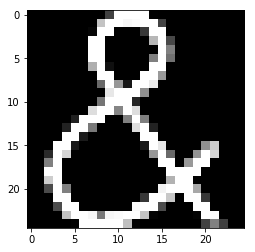

In [16]:
binary_test = np.sum(test, axis=2) < 765
plt.imshow(make_small_feature(binary_test, end_size=25), cmap='gray')

## Do the extraction for all fonts:

In [71]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

index = 0
for font in os.listdir("data/new_sources/font/amp/"):
    if font == ".DS_Store":
        continue
    
    print("\r",index,font,"    ")
    font_fam = font.split(("."))[0]
    ftype, style, family, ver = font_fam.split("_")
    
    font_img = remove_white_bg(standardize(io.imread("data/new_sources/font/amp/" + font)))
    font_binary = np.sum(font_img, axis=2) < 765
    
    small_feature = make_small_feature(font_binary, end_size=25)
    h, w = small_feature.shape
    tempdf = pd.DataFrame(np.transpose(np.reshape(small_feature, (h*w, 1))))
    tempdf['ftype'] = ftype
    tempdf['style'] = style
    tempdf['family'] = family
    tempdf['ver'] = ver
    tempdf['letter'] = '&'

    if index==0:
        fontdf = tempdf
    else:
        fontdf = pd.concat([fontdf, tempdf])
    
    index += 1
    
ampdf = fontdf

 0 sans_amp_futura_bi.png     
 1 sans_amp_futura_bold.png     


/Users/ryan/anaconda3/envs/newcluster/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


 2 sans_amp_futura_cb.png     
 3 sans_amp_futura_ci.png     
 4 sans_amp_futura_co.png     
 5 sans_amp_futura_italic.png     
 6 sans_amp_futura_li.png     
 7 sans_amp_futura_light.png     
 8 sans_amp_futura_orig.png     
 9 sans_amp_helvetica_bi.png     
 10 sans_amp_helvetica_bold.png     
 11 sans_amp_helvetica_cb.png     
 12 sans_amp_helvetica_ci.png     
 13 sans_amp_helvetica_co.png     
 14 sans_amp_helvetica_italic.png     
 15 sans_amp_helvetica_li.png     
 16 sans_amp_helvetica_light.png     
 17 sans_amp_helvetica_orig.png     
 18 serif_amp_times_bi.png     
 19 serif_amp_times_bold.png     
 20 serif_amp_times_cb.png     
 21 serif_amp_times_ci.png     
 22 serif_amp_times_co.png     
 23 serif_amp_times_italic.png     
 24 serif_amp_times_orig.png     


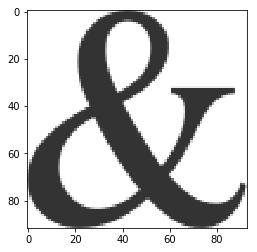

In [72]:
plt.imshow(font_img)

/Users/ryan/anaconda3/envs/newcluster/lib/python3.5/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


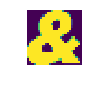

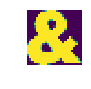

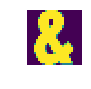

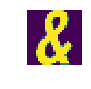

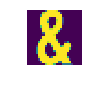

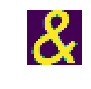

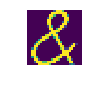

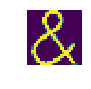

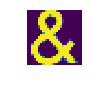

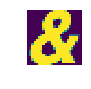

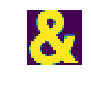

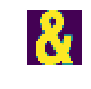

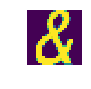

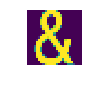

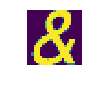

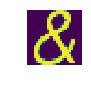

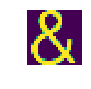

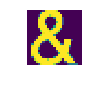

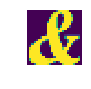

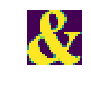

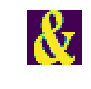

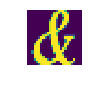

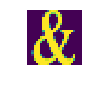

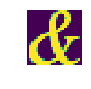

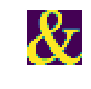

In [73]:
ampmat = ampdf.iloc[:,:625].as_matrix()
for s in range(ampmat.shape[0]):
    plt.figure(figsize=(1,1))
    plt.imshow(ampmat[s,:].reshape((25,25)))
    plt.axis('off')

In [39]:
ampdf

,0,1,2,3,4,5,6,7,8,9,...,620,621,622,623,624,ftype,style,family,ver,letter
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.26,...,0.26,0.5075,0.2475,0.0,0.0,sans,amp,futura,bi,&
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.26,...,0.26,0.5075,0.2475,0.0,0.0,sans,amp,futura,bold,&
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.26,...,0.26,0.5075,0.2475,0.0,0.0,sans,amp,futura,cb,&
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.26,...,0.26,0.5075,0.2475,0.0,0.0,sans,amp,futura,ci,&
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.26,...,0.26,0.5075,0.2475,0.0,0.0,sans,amp,futura,co,&
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.26,...,0.26,0.5075,0.2475,0.0,0.0,sans,amp,futura,italic,&
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.26,...,0.26,0.5075,0.2475,0.0,0.0,sans,amp,futura,li,&
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.26,...,0.26,0.5075,0.2475,0.0,0.0,sans,amp,futura,light,&
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.26,...,0.26,0.5075,0.2475,0.0,0.0,sans,amp,futura,orig,&
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.26,...,0.26,0.5075,0.2475,0.0,0.0,sans,amp,helvetica,bi,&


In [74]:
fontdf = pd.read_csv("data/labeled_fonts.csv")
fontdf = fontdf.loc[fontdf.letter!='-'] 

In [75]:
ampdf.columns = ampdf.columns.values.astype('str')

In [76]:
fontdf = pd.concat([fontdf,ampdf])

In [77]:
fontdf.to_csv("data/labeled_fonts_amp.csv", index=False)